<a href="https://colab.research.google.com/github/nisar8400/Hate-Speech-Detection-using-Transformers-and-LLMs/blob/main/facebook_opt_350m.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/685 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/644 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/441 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/663M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/662M [00:00<?, ?B/s]

Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-350m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5



100%|██████████| 1080/1080 [09:14<00:00,  1.95it/s]


Training Loss: 0.4471
Validation Loss: 0.4021, Validation Accuracy: 0.9132
Epoch 2/5


100%|██████████| 1080/1080 [09:13<00:00,  1.95it/s]


Training Loss: 0.2862
Validation Loss: 0.3703, Validation Accuracy: 0.9165
Epoch 3/5


100%|██████████| 1080/1080 [09:13<00:00,  1.95it/s]


Training Loss: 0.2168
Validation Loss: 0.3237, Validation Accuracy: 0.9367
Epoch 4/5


100%|██████████| 1080/1080 [09:13<00:00,  1.95it/s]


Training Loss: 0.1236
Validation Loss: 0.3643, Validation Accuracy: 0.9384
Epoch 5/5


100%|██████████| 1080/1080 [09:13<00:00,  1.95it/s]


Training Loss: 0.0584
Validation Loss: 0.4398, Validation Accuracy: 0.9319

Final Evaluation Metrics:
Accuracy: 0.9319
              precision    recall  f1-score   support

    Not Hate       0.95      0.98      0.96       621
   Sarcastic       0.98      0.89      0.94       203
    Explicit       0.84      0.86      0.85       203
    Implicit       0.94      0.91      0.92       206

    accuracy                           0.93      1233
   macro avg       0.93      0.91      0.92      1233
weighted avg       0.93      0.93      0.93      1233



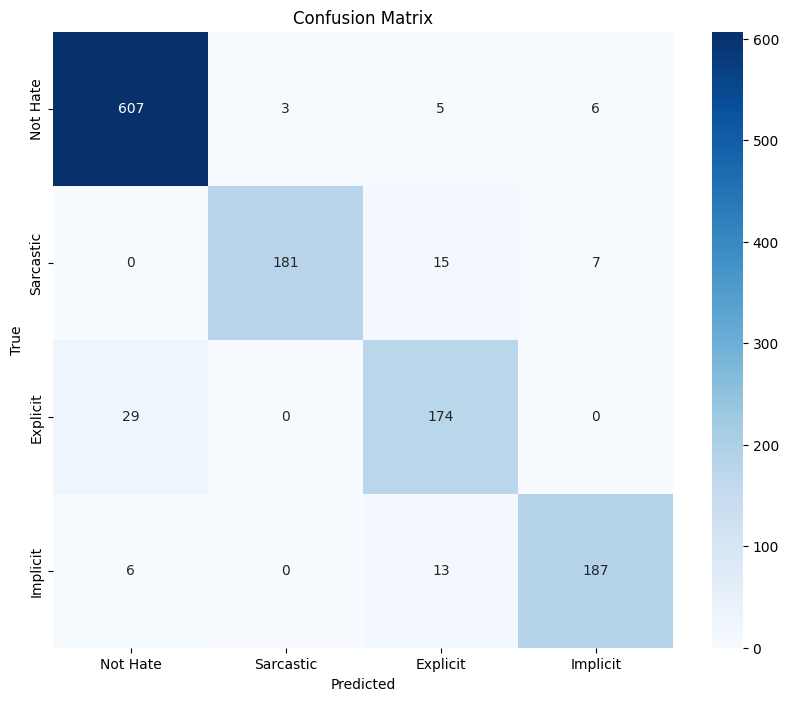

Metrics saved to opt-350m_metrics.txt
Test Loss: 1.0694, Test Accuracy: 0.8533
Sample Predictions: [np.int64(0), np.int64(3), np.int64(3), np.int64(3), np.int64(0), np.int64(3), np.int64(3), np.int64(3), np.int64(3), np.int64(3)]


In [1]:
import pandas as pd
import torch
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_linear_schedule_with_warmup
from torch.optim import AdamW
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import re
import nltk
from nltk.corpus import stopwords

# ------------------------------ NLTK ------------------------------
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

# ------------------------------ Robust loaders ------------------------------
def load_split(path):
    df = pd.read_csv(path, sep=None, engine="python")
    df.columns = df.columns.str.strip()

    if {"sentence", "Normalized_Label"}.issubset(df.columns):
        out = df[["sentence", "Normalized_Label"]].copy()
    else:
        if df.shape[1] == 1:
            s = df.iloc[:, 0].astype(str).str.strip()
            labels = s.str.extract(r"(\S+)$")[0]
            sentence = s.str.replace(r"\s+\S+$", "", regex=True)
            out = pd.DataFrame({"sentence": sentence, "Normalized_Label": labels})
        else:
            merged = [c for c in df.columns if "sentence" in c and "Normalized_Label" in c]
            if merged:
                col = merged[0]
                s = df[col].astype(str)
                labels = s.str.extract(r"([^\t, ]+)$")[0].str.strip()
                sentence = s.str.replace(r"[\t, ]+[^\t, ]+$", "", regex=True).str.strip()
                out = pd.DataFrame({"sentence": sentence, "Normalized_Label": labels})
            elif df.shape[1] == 2:
                out = df.copy(); out.columns = ["sentence", "Normalized_Label"]
            else:
                raise ValueError(f"{path}: cannot infer ['sentence','Normalized_Label']. Found: {list(df.columns)}")

    out["sentence"] = out["sentence"].astype(str).fillna("").str.strip()
    out["Normalized_Label"] = out["Normalized_Label"].astype(str).str.strip()
    out["Normalized_Label"] = out["Normalized_Label"].replace({"Hate": "Not Hate"})  # your rule

    def to_int_or_keep(x):
        try: return int(x)
        except: return x
    out["Normalized_Label"] = out["Normalized_Label"].apply(to_int_or_keep)
    out = out[out["sentence"].str.len() > 0].reset_index(drop=True)
    return out

train_df = load_split("Training.csv")
test_df  = load_split("Testing.csv")
val_df   = load_split("Validation.csv")

# ------------------------------ Label mapping ------------------------------
label_mapping = {
    "Not Hate": 0,
    "Sarcastic": 1, "Sarcastic Hate": 1,
    "Explicit": 2,  "Explicit Hate": 2,
    "Implicit": 3,  "Implicit Hate": 3,
}

def ensure_numeric_labels(df):
    if pd.api.types.is_integer_dtype(df["Normalized_Label"]):
        return df
    mapped = df["Normalized_Label"].map(label_mapping)
    bad = mapped.isna()
    if bad.any():
        unseen = sorted(df.loc[bad, "Normalized_Label"].astype(str).unique().tolist())
        print(f"Warning: dropping {bad.sum()} rows with unmapped labels: {unseen}")
    df = df.loc[~bad].copy()
    df["Normalized_Label"] = mapped.astype(int)
    return df

train_df = ensure_numeric_labels(train_df)
val_df   = ensure_numeric_labels(val_df)
test_df  = ensure_numeric_labels(test_df)

# ------------------------------ Preprocess ------------------------------
class TextPreprocessor:
    def __init__(self):
        self.stop_words = set(stopwords.words('english'))

    def preprocess_text(self, text):
        if not isinstance(text, str): return ""
        text = text.lower()
        text = re.sub(r"http\S+|www\S+|https\S+", "", text)
        text = re.sub(r"[^a-zA-Z\s]", "", text)
        text = re.sub(r"\s+", " ", text).strip()
        text = " ".join([w for w in text.split() if w not in self.stop_words])
        return text

    def preprocess_dataset(self, df):
        df = df.copy()
        df["sentence"] = df["sentence"].astype(str).fillna("").apply(self.preprocess_text)
        return df

preprocessor = TextPreprocessor()
train_df = preprocessor.preprocess_dataset(train_df)
val_df   = preprocessor.preprocess_dataset(val_df)
test_df  = preprocessor.preprocess_dataset(test_df)

# ------------------------------ Dataset/Dataloader ------------------------------
class MentalHealthDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, tokenizer, max_len, label_column='Normalized_Label'):
        self.tokenizer = tokenizer
        self.data = dataframe.reset_index(drop=True)
        self.max_len = max_len
        self.label_column = label_column

    def __len__(self): return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        text = row["sentence"]
        inputs = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt"
        )
        input_ids = inputs["input_ids"].squeeze(0)
        attention_mask = inputs["attention_mask"].squeeze(0)
        label = int(row[self.label_column])
        return {"input_ids": input_ids, "attention_mask": attention_mask, "labels": torch.tensor(label, dtype=torch.long)}

# ------------------------------ Classifier ------------------------------
class MentalHealthClassifier:
    def __init__(self, model_name, num_labels, max_len, batch_size, lr, epochs, label_column='Normalized_Label'):
        self.tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=False)
        # OPT: set padding
        if self.tokenizer.pad_token is None:
            self.tokenizer.pad_token = self.tokenizer.eos_token
        self.tokenizer.padding_side = "left"

        self.model = AutoModelForSequenceClassification.from_pretrained(
            model_name, num_labels=num_labels, pad_token_id=self.tokenizer.pad_token_id
        ).to(device)

        self.max_len = max_len
        self.batch_size = batch_size
        self.lr = lr
        self.epochs = epochs
        self.model_name = model_name
        self.label_column = label_column

    def create_dataloader(self, dataframe, shuffle=True):
        dataset = MentalHealthDataset(dataframe, self.tokenizer, self.max_len, self.label_column)
        return DataLoader(dataset, batch_size=self.batch_size, shuffle=shuffle)

    def train(self, train_loader, val_loader):
        optimizer = AdamW(self.model.parameters(), lr=self.lr)
        total_steps = len(train_loader) * self.epochs
        scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

        for epoch in range(self.epochs):
            print(f"Epoch {epoch+1}/{self.epochs}")
            self.model.train()
            train_loss = 0.0

            for batch in tqdm(train_loader):
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                labels = batch["labels"].to(device)

                outputs = self.model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                train_loss += loss.item()

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                scheduler.step()

            avg_train_loss = train_loss / max(1, len(train_loader))
            print(f"Training Loss: {avg_train_loss:.4f}")
            val_loss, val_acc = self.evaluate(val_loader)
            print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

        self.final_evaluation(val_loader)

    def evaluate(self, dataloader):
        self.model.eval()
        total_loss = 0.0
        predictions, true_labels = [], []
        with torch.no_grad():
            for batch in dataloader:
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                labels = batch["labels"].to(device)

                outputs = self.model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                logits = outputs.logits

                total_loss += loss.item()
                preds = torch.argmax(logits, dim=1).cpu().numpy()
                true_labels.extend(labels.cpu().numpy())
                predictions.extend(preds)

        avg_loss = total_loss / max(1, len(dataloader))
        accuracy = accuracy_score(true_labels, predictions)
        return avg_loss, accuracy

    def final_evaluation(self, val_loader):
        self.model.eval()
        predictions, true_labels = [], []
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                labels = batch["labels"].to(device)

                outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
                logits = outputs.logits
                preds = torch.argmax(logits, dim=1).cpu().numpy()
                true_labels.extend(labels.cpu().numpy())
                predictions.extend(preds)

        accuracy = accuracy_score(true_labels, predictions)
        target_names = ['Not Hate', 'Sarcastic', 'Explicit', 'Implicit']
        report = classification_report(true_labels, predictions, target_names=target_names, labels=[0,1,2,3], output_dict=True, zero_division=0)
        cm = confusion_matrix(true_labels, predictions, labels=[0,1,2,3])

        print("\nFinal Evaluation Metrics:")
        print(f"Accuracy: {accuracy:.4f}")
        print(classification_report(true_labels, predictions, target_names=target_names, labels=[0,1,2,3], zero_division=0))

        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
        plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('Confusion Matrix'); plt.show()

        self.save_metrics(accuracy, report, cm)

    def save_metrics(self, accuracy, report, cm):
        model_base_name = self.model_name.split('/')[-1]
        metrics_file = f"{model_base_name}_metrics.txt"   # -> facebook/opt-350m_metrics.txt
        with open(metrics_file, 'w') as f:
            f.write("Evaluation Metrics:\n")
            f.write(f"Accuracy: {accuracy:.4f}\n\n")
            f.write("Classification Report:\n")
            for label, metrics in report.items():
                if isinstance(metrics, dict):
                    f.write(f"{label}:\n")
                    for metric, value in metrics.items():
                        f.write(f"  {metric}: {value:.4f}\n")
                else:
                    f.write(f"{label}: {metrics:.4f}\n")
            f.write("\nConfusion Matrix:\n")
            f.write(str(cm))
        print(f"Metrics saved to {metrics_file}")

    def predict(self, test_loader):
        self.model.eval()
        predictions = []
        with torch.no_grad():
            for batch in test_loader:
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
                logits = outputs.logits
                preds = torch.argmax(logits, dim=1).cpu().numpy()
                predictions.extend(preds)
        return predictions

# ------------------------------ Run pipeline ------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
model_name = "facebook/opt-350m"
num_labels = 4
max_len = 512          # OPT supports long contexts; 512 is fine for classification
batch_size = 8
lr = 2e-5
epochs = 5

classifier = MentalHealthClassifier(model_name, num_labels, max_len, batch_size, lr, epochs)

train_loader = classifier.create_dataloader(train_df)
val_loader   = classifier.create_dataloader(val_df, shuffle=False)
test_loader  = classifier.create_dataloader(test_df, shuffle=False)

classifier.train(train_loader, val_loader)

test_loss, test_accuracy = classifier.evaluate(test_loader)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

predictions = classifier.predict(test_loader)
print("Sample Predictions:", predictions[:10])
